In [3]:
import celmech as cm
import rebound as rb
import numpy as np
from hadden_theory.test_particle_secular_hamiltonian import SyntheticSecularTheory, TestParticleSecularHamiltonian
from celmech.miscellaneous import frequency_modified_fourier_transform as fmft
from matplotlib import pyplot as plt
from celmech.poisson_series import PoissonSeriesHamiltonian 
import pandas as pd

In [4]:
import pickle
from hadden_theory import test_particle_secular_hamiltonian
# hack to make pickle load work
import sys
sys.modules['test_particle_secular_hamiltonian'] = test_particle_secular_hamiltonian
with open("hadden_theory/solar_system_synthetic_solution.bin","rb") as fi:
    solar_system_synthetic_theory=pickle.load(fi)

In [5]:
truncate_dictionary = lambda d,tol: {key:val for key,val in d.items() if np.abs(val)>tol}
simpler_secular_theory = SyntheticSecularTheory(
    solar_system_synthetic_theory.masses,
    solar_system_synthetic_theory.semi_major_axes,
    solar_system_synthetic_theory.omega_vector,
    [truncate_dictionary(x_d,1e-3) for x_d in solar_system_synthetic_theory.x_dicts],
    [truncate_dictionary(y_d,1e-3) for y_d in solar_system_synthetic_theory.y_dicts]
)

In [6]:
# Read the table with the defined column specifications
df = pd.read_fwf('MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them

df.infer_objects()
for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
	df[c] = pd.to_numeric(df[c])

df.head()

,Des'n,H,G,Epoch,M,Peri.,Node,Incl.,e,n,a
1,00001,3.34,0.15,K239D,60.07879,73.42179,80.25496,10.58688,0.078913,.21410680,2.767254
2,00002,4.12,0.15,K239D,40.59806,310.87290,172.91881,34.92584,0.230229,.21377378,2.770128
3,00003,5.17,0.15,K239D,37.02310,247.73791,169.83920,12.99055,0.256213,.22600445,2.669263
4,00004,3.22,0.15,K239D,169.35183,151.66223,103.71002,7.14218,0.089449,.27152244,2.361922
5,00005,7.00,0.15,K239D,303.39802,359.13666,141.46909,5.35867,0.187439,.23826556,2.576886


In [7]:
labels = pd.read_fwf('proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])
labels.head()

,propa,da,prope,de,propsini,dsini,g,s,H,NumOpps,Des'n
0,2.767028,2.300000e-05,0.115193,0.00016,0.167560,0.000013,54.253800,-59.249995,3.34,123,00001
1,2.771276,1.200000e-04,0.280234,0.00034,0.546016,0.000045,-1.372312,-46.451120,4.12,121,00002
2,2.669376,7.500000e-06,0.233600,0.00001,0.229144,0.000003,43.858531,-61.476025,5.17,114,00003
3,2.361512,5.900000e-08,0.099452,0.00014,0.111023,0.000180,36.882605,-39.610314,3.22,110,00004
4,2.577657,2.900000e-05,0.171249,0.01200,0.076113,0.001400,52.506470,-51.132322,7.00,87,00005


In [8]:
merged_df = pd.merge(df, labels, on="Des'n", how="inner")
asteroid_index = 4
row = merged_df.iloc[asteroid_index]
row

Des'n           00005
H_x              7.00
G                0.15
Epoch           K239D
M           303.39802
Peri.       359.13666
Node        141.46909
Incl.         5.35867
e            0.187439
n           .23826556
a            2.576886
propa        2.577657
da           0.000029
prope        0.171249
de              0.012
propsini     0.076113
dsini          0.0014
g            52.50647
s          -51.132322
H_y               7.0
NumOpps            87
Name: 4, dtype: object

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')


/home/miniconda3/envs/lshen/lib/python3.12/site-packages/rebound/simulationarchive.py:152: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.synchronize().", RuntimeWarning)


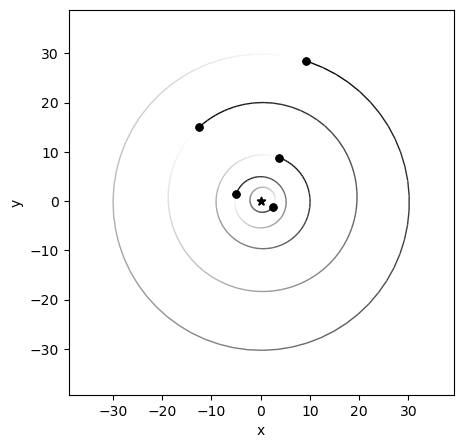

In [9]:
sim = rb.Simulation()
sim.add("Sun")
sim.add("Jupiter")
sim.add("Saturn")
sim.add("Uranus")
sim.add("Neptune")
sim.N_active = sim.N
# add some asteroids
sim.add(a=row['a'], e=row['e'], inc=row['Incl.']*np.pi/180, Omega=row['Node']*np.pi/180, omega=row['Peri.']*np.pi/180, M=row['M'], primary=sim.particles[0])
sim.move_to_com()
cm.nbody_simulation_utilities.align_simulation(sim)
rb.OrbitPlot(sim)
# try:
#     results = cm.nbody_simulation_utilities.get_simarchive_integration_results("vesta+outer_solar_system.sa",coordinates='heliocentric')
# except:
sim.integrator = 'whfast'
sim.dt = np.min([p.P for p in sim.particles[1:]]) / 25.
sim.ri_whfast.safe_mode = 0
Tfin_approx = 0.5e7 * 2*np.pi
total_steps = np.ceil(Tfin_approx / sim.dt)
Tfin = total_steps * sim.dt + sim.dt
Nout = 4096
sim.save_to_file("outer_solar_system.sa",step=int(np.floor(total_steps/Nout)),delete_file=True)
sim.integrate(Tfin,exact_finish_time=0)
results = cm.nbody_simulation_utilities.get_simarchive_integration_results("outer_solar_system.sa",coordinates='heliocentric')

In [10]:
results['X'] = np.sqrt(2*(1-np.sqrt(1-results['e']**2))) * np.exp(1j * results['pomega'])
results['Y'] = (1-results['e']**2)**(0.25) * np.sin(0.5 * results['inc'] ) * np.exp(1j * results['Omega'])

In [11]:
tp_h = TestParticleSecularHamiltonian(np.mean(results['a'][-1]),simpler_secular_theory)
x_numerical = results['X'][-1]
y_numerical = 2*results['Y'][-1]
x_linear,y_linear = tp_h.linear_theory_solution(x_numerical[0],y_numerical[0],results['time'])

# Build `PoissonSeriesHamiltonian` from 4th order expansion


In [12]:
from celmech.disturbing_function import list_secular_terms
from celmech.poisson_series import PoissonSeries

# leading order Hamiltonian
h2_series = tp_h.H2_poisson_series()

# list of 4th order terms
sec_terms = list_secular_terms(4,4)
h4_series = PoissonSeries(2,tp_h.synthetic_secular_theory.N_freq)
for k,nu in sec_terms:
    for i in range(tp_h.synthetic_secular_theory.N_planets):
        h4_series+=tp_h.DFTerm_poisson_series(i,k,nu)

# Strip terms that only depend on angles and not x,y,\bar{x},\bar{y}
angle_only_term  = lambda term: (np.all(term.k==0) and np.all(term.kbar==0))
h4_series_reduced = PoissonSeries.from_PSTerms([term for term in h4_series.terms if not angle_only_term(term)])

# Hamiltonian
h_tot = h2_series + h4_series_reduced
print("{} terms total".format(len(h_tot.terms)))
ham_ps = PoissonSeriesHamiltonian(h_tot)

704 terms total


In [13]:
h_tot.N, h_tot.M

(2, 7)

In [14]:
from celmech.rk_integrator import RKIntegrator

In [15]:
dt = 0.1 * np.min(2*np.pi / np.abs((tp_h.g0,tp_h.s0)))

In [16]:
integrator = RKIntegrator(
    ham_ps.flow,
	lambda x: (ham_ps.flow(x), ham_ps.jacobian(x)),
    Ndim=2*(ham_ps.N+ham_ps.M),
    dt=dt,
    rtol=1e-4,
    atol=1e-7,
    rk_method='GL6',
    rk_root_method='Newton',
    max_iter=10
)


### numerically integrate 4th order Hamiltonian

In [17]:
u0 = x_numerical[0] - np.sum(list(tp_h.F_e.values()))
v0 = y_numerical[0] - np.sum(list(tp_h.F_inc.values()))
_RT2 = np.sqrt(2)
X = np.zeros(2*(h_tot.M+h_tot.N))
X[:2] = -1 * _RT2 * np.imag(np.array([u0,v0]))
X[h_tot.M+h_tot.N:h_tot.M+h_tot.N+2] = _RT2 * np.real(np.array([u0,v0]))

steps = 200
times = np.arange(steps) * integrator.dt
X_rk = np.zeros((steps,X.size))
for i in range(steps):
    X_rk[i] = X
    X = integrator.rk_step(X)


/tmp/ipykernel_256895/134305743.py:13: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  X = integrator.rk_step(X)


In [18]:
from scipy.integrate import solve_ivp
# Tfin = 0.1e6 * 2*np.pi
Tfin = steps * integrator.dt
Nout = 200
t_eval = np.linspace(0,Tfin,Nout)
soln_h = solve_ivp(
    lambda t,y: ham_ps.flow(y),
    (0,np.max(times)),
    X_rk[0],
    method="Radau",
    t_eval=times,
    jac = lambda t,y: ham_ps.jacobian(y)
)


# Plot comparison of solutions

Text(0.5, 1.0, 'Vesta secular evolution')

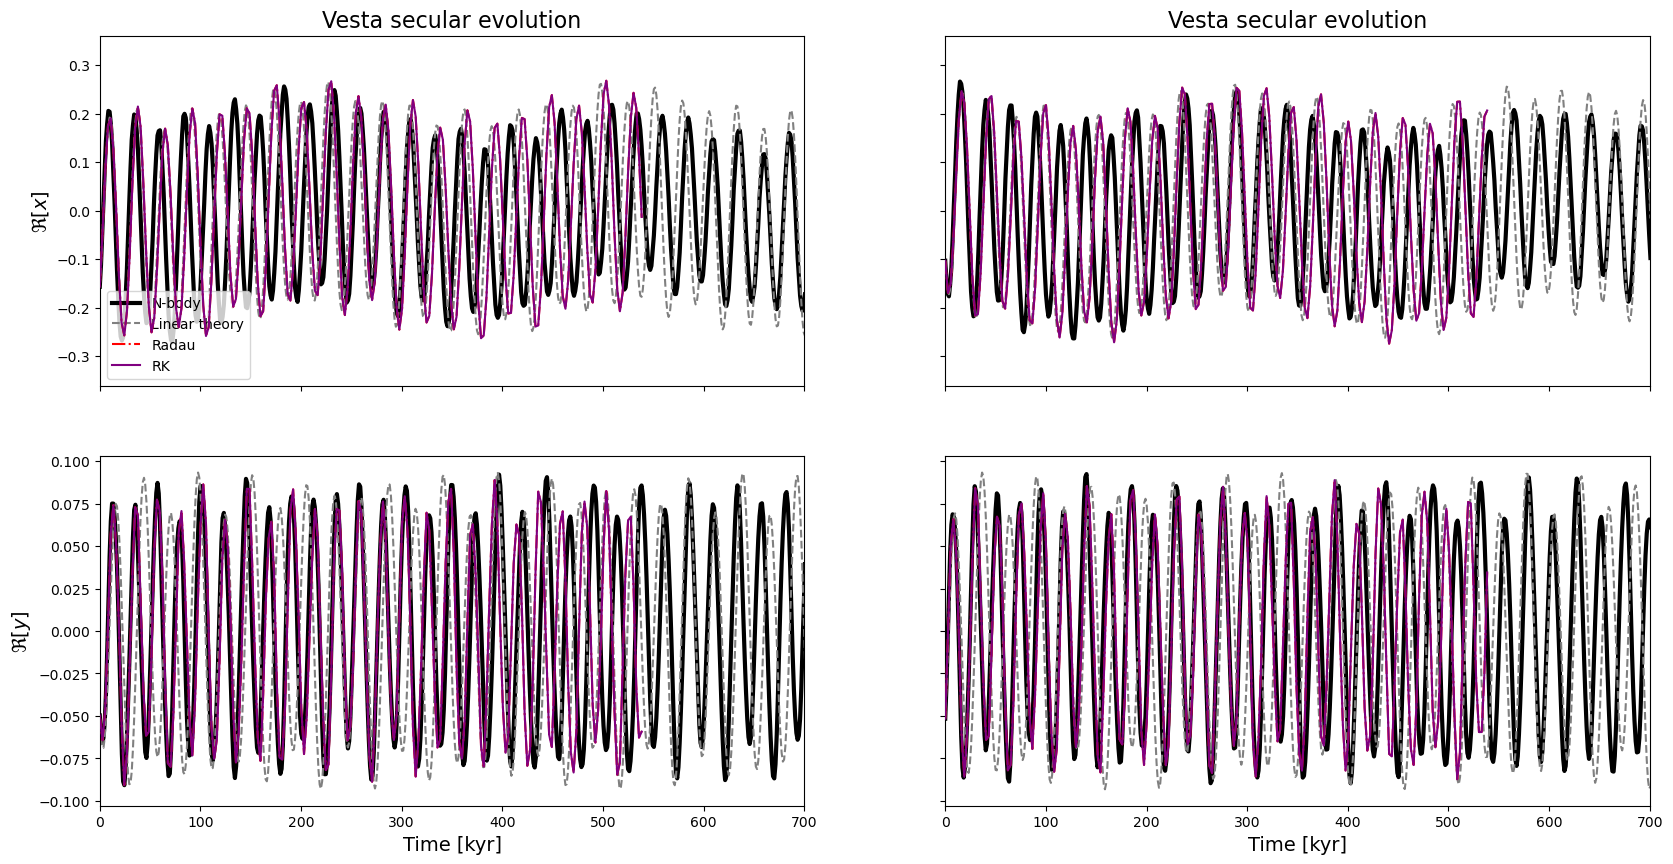

In [19]:
u_soln = (soln_h.y[h_tot.M+h_tot.N] - 1j * soln_h.y[0]) / np.sqrt(2)
F_e_soln = np.sum([amp*np.exp(1j*(m @ soln_h.y[h_tot.N:h_tot.M+h_tot.N])) for m,amp in tp_h.F_e.items()],axis=0)    
x_soln = u_soln+F_e_soln

v_soln = (soln_h.y[1+h_tot.M+h_tot.N] - 1j * soln_h.y[1]) / np.sqrt(2)
F_inc_soln = np.sum([amp*np.exp(1j*(m @ soln_h.y[h_tot.N:h_tot.M+h_tot.N])) for m,amp in tp_h.F_inc.items()],axis=0)    
y_soln = v_soln+F_inc_soln

u_rk_soln = (X_rk.T[h_tot.M+h_tot.N] - 1j * X_rk.T[0]) / np.sqrt(2)
F_e_rk_soln = np.sum([amp*np.exp(1j*(m @ X_rk.T[h_tot.N:h_tot.M+h_tot.N])) for m,amp in tp_h.F_e.items()],axis=0)    
x_rk_soln = u_rk_soln+F_e_rk_soln

v_rk_soln = (X_rk.T[1+h_tot.M+h_tot.N] - 1j * X_rk.T[1]) / np.sqrt(2)

F_inc_rk_soln = np.sum([amp*np.exp(1j*(m @ X_rk.T[h_tot.N:h_tot.M+h_tot.N])) for m,amp in tp_h.F_inc.items()],axis=0)    

y_rk_soln = v_rk_soln+F_inc_rk_soln

fig,ax = plt.subplots(2,2,sharex=True,figsize=(20,10),sharey='row')

for j,fn in zip((0,1),(np.real,np.imag)):
    ax[0,j].plot(results['time']/(2e3*np.pi),fn(x_numerical),lw=3,color='k',label="N-body")
    ax[0,j].plot(results['time']/(2e3*np.pi),fn(x_linear),'--',color='gray',label="Linear theory")
    ax[0,j].plot(soln_h.t/(2e3*np.pi),fn(x_soln),'r-.',zorder=99,label="Radau")
    ax[0,j].plot(times/(2e3*np.pi),fn(x_rk_soln),'-',color='purple',zorder=99,label="RK")

    ax[1,j].plot(results['time']/(2e3*np.pi),fn(y_numerical),lw=3,color='k')
    ax[1,j].plot(results['time']/(2e3*np.pi),fn(y_linear),'--',color='gray')
    ax[1,j].plot(soln_h.t/(2e3*np.pi),fn(y_soln),'r-.',zorder=99)
    ax[1,j].plot(times/(2e3*np.pi),fn(y_rk_soln),'-',color='purple',zorder=99,label="RK")

ax[0,0].legend(loc = 'lower left')
plt.xlim(0,.7e3)

ax[1,0].set_xlabel("Time [kyr]",fontsize=14)
ax[1,1].set_xlabel("Time [kyr]",fontsize=14)
ax[0,0].set_ylabel(r"$\Re[x]$",fontsize=14)
ax[1,0].set_ylabel(r"$\Re[y]$",fontsize=14)
ax[0,0].set_title("Vesta secular evolution",fontsize=16)
ax[0,1].set_title("Vesta secular evolution",fontsize=16)

Leading order approximation of proper e (non-constant behaviour due to nonlinear order term corrections)

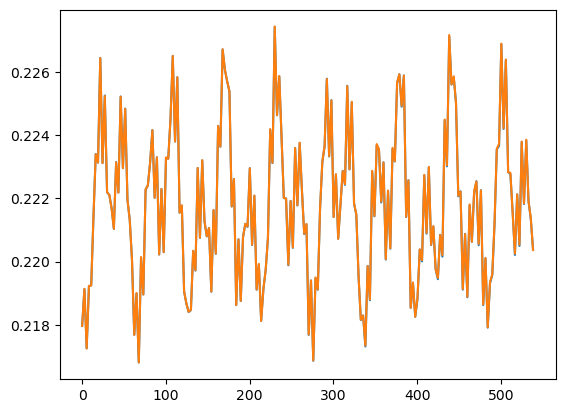

In [20]:
plt.plot(times/(2e3*np.pi),np.abs(u_rk_soln))
plt.plot(soln_h.t/(2e3*np.pi),np.abs(u_soln))

# check energy conservation

Text(0, 0.5, '$|\\Delta E / E|$')

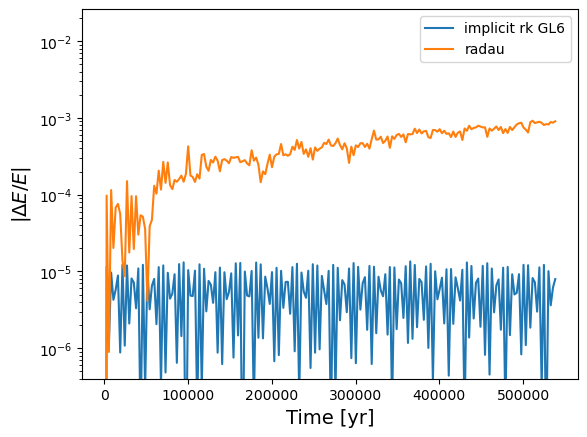

In [21]:
# Radau is not great; something fishy going on!?
energy = np.array([ham_ps(yy) for yy in X_rk])
plt.plot(times/(2*np.pi),np.abs(energy/energy[0] - 1),label='implicit rk GL6')
energy = np.array([ham_ps(yy) for yy in soln_h.y.T])
plt.plot(soln_h.t/(2*np.pi),np.abs(energy/energy[0] - 1),label='radau')
plt.yscale('log')
plt.legend()
plt.ylim(ymin=0.4e-6)
plt.xlabel("Time [yr]",fontsize=14)
plt.ylabel(r"$|\Delta E / E|$",fontsize=14)

(0.22181109678829714, 0.22510563016724683)

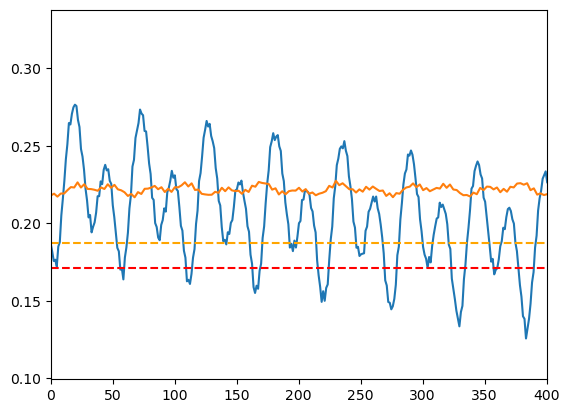

In [22]:
X_mag = abs(x_soln)
Y_mag = abs(y_soln)

e = np.sqrt(1 - (1 - X_mag**2/2) ** 2)
I = 2 * np.arcsin(Y_mag / (1 - e**2) ** (1/4))

e_avg = np.average(e)
I_avg = np.average(I)

plt.plot(results['time']/(2e3*np.pi), results['e'][-1])
plt.axhline(y=row["prope"], color='r', linestyle='--')
plt.axhline(y=row["e"], color='orange', linestyle='--')
# plt.plot(times/(2e3*np.pi),np.abs(u_rk_soln))
plt.plot(soln_h.t/(2e3*np.pi),np.abs(u_soln))
plt.xlim(0, 400)

np.average(abs(u_rk_soln)), np.average(results["e"][-1])

In [28]:
import pandas as pd
import numpy as np

if sim.N > 6:
    inner_planet_offset = 4
else:
    inner_planet_offset = 0

asteroid_X = results['X'][4]
asteroid_ecc_result = fmft(results['time'], asteroid_X, 14)
asteroid_freqs = np.array(list(asteroid_ecc_result.keys()))
asteroid_freqs_arcsec_per_yr = asteroid_freqs * 60 * 60 * 180 / np.pi * (2 * np.pi)

asteroid_data = []
for g in asteroid_freqs[:6]:
    freq_arcsec_per_yr = g * 60 * 60 * 180 / np.pi * (2 * np.pi)
    amplitude = np.abs(asteroid_ecc_result[g])
    asteroid_data.append({
        "g (fmft)": freq_arcsec_per_yr,
        "Amplitude": amplitude
    })

# Create DataFrame
asteroid_df = pd.DataFrame(asteroid_data)

# Display or return
asteroid_df

,g (fmft),Amplitude
0,52.793201,0.147928
1,51.839111,0.110253
2,52.309931,0.086492
3,53.328138,0.076312
4,51.368777,0.046633
5,4.245982,0.039314


In [26]:
sorted_solutions = sorted(tp_h.F_e.items(), key=lambda item: np.abs(item[1]), reverse=True)
asteroid_h_data = []
for m, amp in sorted_solutions:
	freq = np.dot(m, solar_system_synthetic_theory.omega_vector)
	asteroid_h_data. append ({
		"g (linear)": freq * 60*60*180 / np.pi * (2*np.pi),
		"Amplitude": np.abs (amp),
		"Period": 3600/(freq * 60*60*180/np.pi * (2*np.pi))
	})
asteroid_hadden_df = pd. DataFrame(asteroid_h_data)
asteroid_hadden_df


,g (linear),Amplitude,Period
0,4.245731,2.845165e-02,847.910530
1,28.273435,2.093975e-02,127.328002
2,3.089471,1.160004e-03,1165.248153
3,52.301139,2.230190e-04,68.832153
4,0.672788,1.578868e-07,5350.870460
